# Ejemplo de tarea resuelta

## Preparación del ambiente de computación

Para poder ejecutar los análisis de este cuaderno es necesario:

1. Instalar BLAST.
2. Descomprimir el archivo taxdb.btd.gz

Para hacerlo de forma automática desde R, disponemos en esta carpeta del pequeño *script* de BASH: `preparar_ambiente.sh`. Esta vez, sólo hace falta ejecutar el bloque siguiente, sin necesidad de salir del cuaderno:

In [ ]:
system2(command = './preparar_ambiente.sh', wait = TRUE)

## Introducción
El objetivo de este análisis es explorar la distribución taxonómica de las secuencias homólogas a la de la protoclorofílida reductasa dependiente de luz (LPOR) de *Arabidopsis thaliana*.

## Métodos
La base de datos de secuencias en la que voy a buscar homologías és Swissprot, porque es una base de datos de proteínas ya instalada localmente en este ambiente.

Uilizaré **blastp** (Altschul *et al.*, 1990) con diferentes umbrales de valor E, para determinar a qué ritmo aumenta la distribución taxonómica de las secuencias encontradas a medida que se relaja el grado de similitud exigido. Es decir, a medida que acepto como resultados del **blastp** secuencias con un valor E mayor. 

## Resultados
### BLASTP individual
Primero, ejecuto una única búsqueda con **blastp**, usando un umbral de valor E de 1.0e-50, que es muy exigente: sólo las secuencias extremadamente parecidas a la original apareceran en los resultados.

In [1]:
# Observa entre los argumentes la especificación del formato de salida,
# "-outfmt". Si hace falta, desliza la barra para visualizar la línea completa.
BlastpOut01 <- system2(command = 'blastp',
                      args = c('-db', 'swissprot',
                              '-query', 'LPOR.fas',
                              '-evalue', '1.0e-50',
                              '-outfmt', '"7 saccver pident length qstart qend sstart send evalue staxid ssciname sblastname"'),
                      stdout = TRUE)

# El resultado del comando anterior, guardado en "BlastOut01", es un montón de
# texto plano. Con las funciones textConnection() y read.table(), lo transformamos
# en un "data frame", una tabla donde cada columna es una variable. La opción
# "col.names" en read.table() sirve para dar nombre a las columnas.
TablaOut01 <- read.table(textConnection(BlastpOut01),
                        sep = '\t',
                        col.names = c('saccver', 'pident', 'length', 'qstart',
                                     'qend', 'sstart', 'send', 'evalue', 'staxid',
                                     'ssciname', 'sblastname'))
# Dimensiones de la tabla:
dim(TablaOut01)

[1] 16 11

In [2]:
TablaOut01

saccver,pident,length,qstart,qend,sstart,send,evalue,staxid,ssciname,sblastname
<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<fct>,<fct>
O48741.1,100.000,401,1,401,1,401,0.00e+00,3702,Arabidopsis thaliana,eudicots
Q9SDT1.1,78.856,402,1,401,1,398,0.00e+00,4039,Daucus carota,eudicots
Q41249.1,77.612,402,1,401,1,398,0.00e+00,3659,Cucumis sativus,eudicots
Q42536.2,75.245,408,1,401,1,405,0.00e+00,3702,Arabidopsis thaliana,eudicots
Q8W3D9.1,74.384,406,1,401,1,398,0.00e+00,39947,Oryza sativa Japonica Group,monocots
Q42850.1,73.945,403,1,401,1,395,0.00e+00,4513,Hordeum vulgare,monocots
Q01289.1,77.723,404,1,401,1,399,0.00e+00,3888,Pisum sativum,eudicots
P21218.3,76.049,405,1,401,1,401,0.00e+00,3702,Arabidopsis thaliana,eudicots
O80333.1,66.093,407,2,400,66,457,0.00e+00,56867,Marchantia paleacea,liverworts


La tabla de resultados incluye 16 secuencias encontradas, incluyendo la misma secuencia usada como *query*. Las columnas de la tabla són:

- **saccver**: número de acceso o identificador de la secuencia encontrada (*subject*).
- **pident**: porcentaje de identidad entre la *query* y el *subject* en su alineamiento local.
- **length**: longitud del alineamiento entre *query* y *subject*.
- **qstart**: primera posición de la *query* alineada.
- **qend**: última posición alineada en la *query*.
- **sstart**: primera posición de la *subject* alineada.
- **send**: última posición de la *subject* alineada.
- **evalue**: valor E del alineamiento. Es decir, número de alineamientos de igual o mejor puntuación esperados por azar en una base de datos igual de grande.
- **staxid**: identificador de la especie a la que pertenece la *subject*, en la base de datos de taxonomía del NCBI.
- **ssciname**: nombre científico de la especie a la que pertenece la *subject*.
- **sblastname**: nombre de un grupo taxonómico de rango superior al que pertenece la *subject*, usado para facilitar la interpretación.

### BLASTP en serie
Para ver cómo aumenta el número de secuencias a medida que aumenta el umbral de valor E, deberíamos repetir la búsqueda unas cuantas veces, con valores del parámetro `-evalue` diferentes. Podemos hacerlo de forma automática, por ejemplo, usando la función `lapply()`. El código siguiente ejecutará una búsqueda de **blastp** para cada valor del vector `Valores_E_maximos`. El resultado será una lista de tablas, como la anterior. 

In [3]:
Valores_E_maximos <- c('1.0e-50', '1.0e-40', '1.0e-30', '1.0e-20', '1.0e-10',
                       '1.0e-08', '1.0e-06', '1.0e-04', '1.0e-02', '1')

# La función lapply() aplicará una función (segundo argumento) sobre
# cada uno de los valores de la lista o vector indicados en el primer
# argumento (Valores_E_maximos, en este caso). La función que aplicamos
# la definimos entre llaves ("{}"). Incluye todos los pasos necesarios
# para obtener una tabla de resultados como la anterior.
Lista_de_Tablas <- lapply(Valores_E_maximos,
                          function(x) {
                              BlastpOut <- system2(
                                  command = 'blastp',
                                  args = c('-db', 'swissprot',
                                           '-query', 'LPOR.fas',
                                           '-evalue', x,
                                           '-outfmt',
                                           '"7 saccver pident length qstart qend sstart send evalue staxid ssciname sblastname"'),
                                  stdout = TRUE)
                              read.table(textConnection(BlastpOut),
                                         sep = '\t',
                                         col.names = c('saccver', 'pident', 'length', 'qstart',
                                            'qend', 'sstart', 'send', 'evalue', 'staxid',
                                            'ssciname', 'sblastname'))
                          })

El objeto `Lista_de_Tablas` guarda las tablas de resultados de los diez **blastp** ejecutados. Podemos acceder a una tabla individual mediante los dobles corchetes:

In [4]:
tail(Lista_de_Tablas[[3]])

,saccver,pident,length,qstart,qend,sstart,send,evalue,staxid,ssciname,sblastname
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<fct>,<fct>
14,Q39617.1,70.253,316,86,401,82,396,4.60e-164,3055,Chlamydomonas reinhardtii,green algae
15,O66148.2,56.698,321,87,401,4,322,4.04e-122,1184,Leptolyngbya boryana,cyanobacteria
16,Q59987.2,53.918,319,89,401,6,322,1.54e-113,1111708,Synechocystis sp. PCC 6803 substr. Kazusa,cyanobacteria
17,Q803A8.1,36.562,320,93,398,125,402,2.31e-33,7955,Danio rerio,bony fishes
18,Q91WL8.1,34.185,313,91,398,126,405,5.28e-33,10090,Mus musculus,rodents
19,A2RVM0.1,32.588,313,91,397,31,312,3.24e-32,3702,Arabidopsis thaliana,eudicots


Para saber cuántas secuencias homólogas ha encontrado **blastp** en la base de datos con cada valor del parámetro `-evalue`, aplico la función `dim()` que devuelve las dimensiones del objeto en cuestión (número de filas y de columnas) y me quedo con la primera dimensión (número de filas):

In [5]:
Numero_de_resultados <- sapply(Lista_de_Tablas, function(x) dim(x)[1])
Numero_de_resultados

[1]  16  16  19  27  48  58  71  87 144 313

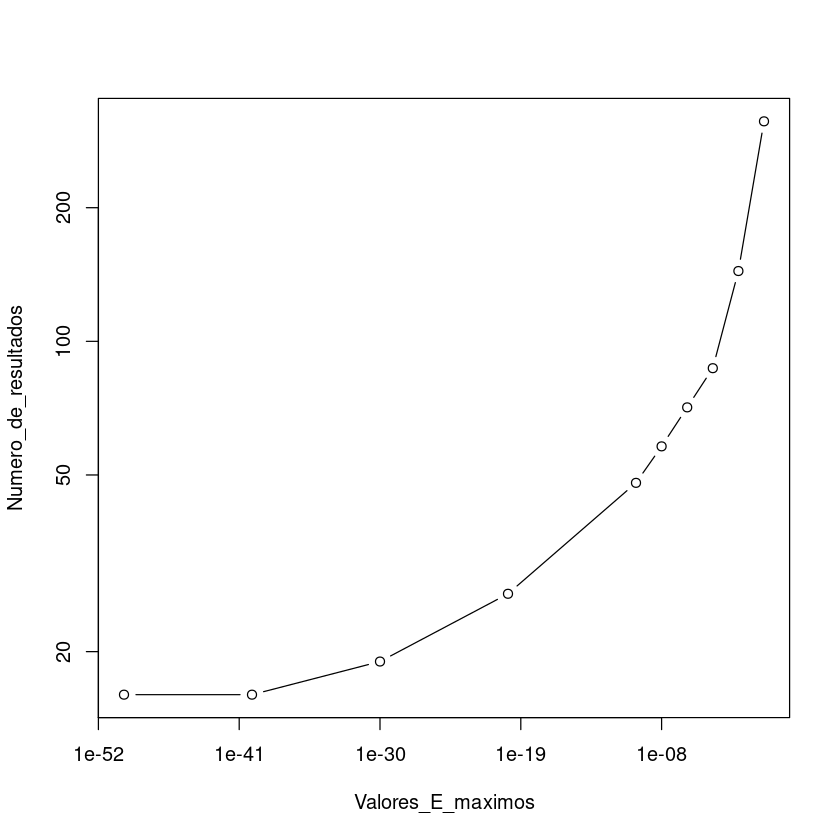

In [10]:
# En la representación gráfica, podemos usar escala logarítmica solamente
# en un eje ("log='x'"), en los dos, o en ninguno.
plot(Valores_E_maximos, Numero_de_resultados, log = 'xy', type = 'b')

A continuación examino la relación entre la longitud del alineamiento y el valor E de los resultados guardados en la última tabla, la número 10, en la que he usado un valor E de 1 y que contiene un mayor número de resultados.

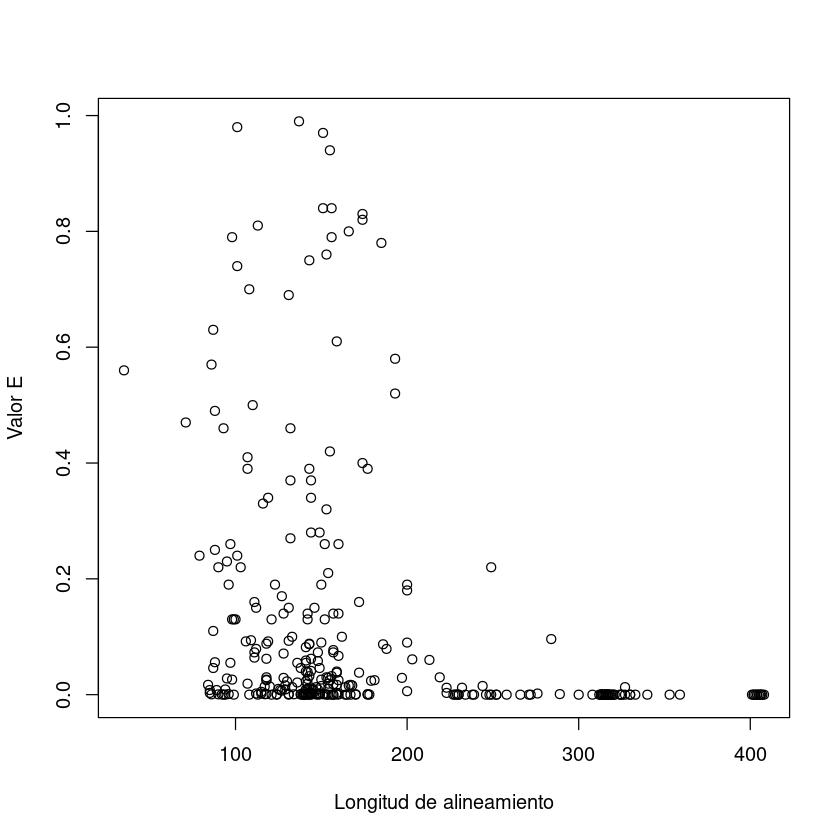

In [11]:
# El símbolo "$" extrae de un "data frame" una columna. Si ejecutas
# "Lista_de_Tablas[[3]]$length", verás que el resultado es el vector
# de las longitudes de los alineamientos de la tercera tabla, por ejemplo.
plot(Lista_de_Tablas[[10]]$length, Lista_de_Tablas[[10]]$evalue,
     xlab = 'Longitud de alineamiento', ylab = 'Valor E')

Aunque la proteína LPOR es de unos 400 aminoácidos, existen alineamientos de menos de 100. Esto indica que existen muchas proteínas en la base de datos que presentan homología **parcial** con LPOR. Es decir, que muchos de estos resultados corresponden a proteínas que solo se parecen a LPOR en un fragmento concreto; probablemente un dominio de función conservada. Cabe preguntar qué posiciones de LPOR son esas que participan en los alineamientos parciales. 

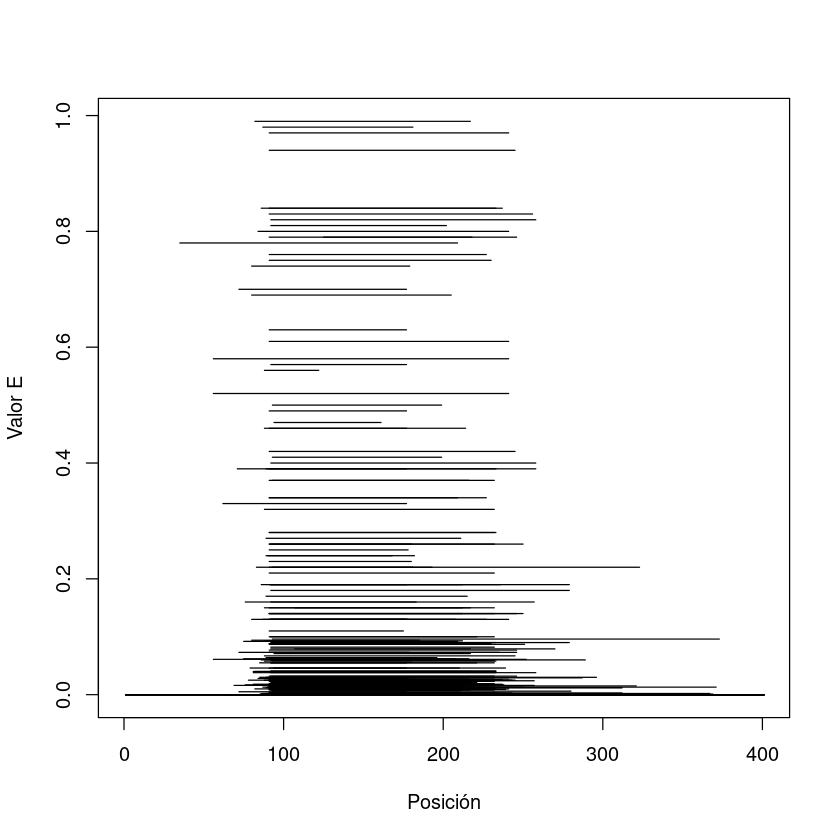

In [12]:
inicios <- Lista_de_Tablas[[10]]$qstart
finales <- Lista_de_Tablas[[10]]$qend
valoresE <- Lista_de_Tablas[[10]]$evalue

# La función segments() añade segmentos a un gráfico previo. Por eso, represento
# antes un gráfico con los rangos adecuados, pero vacío (type='n'). Para determinar
# el rango del eje horizontal, determino primero el valor máximo de "qend".
AlineamientoMaximo <- max(Lista_de_Tablas[[10]]$qend)
plot(c(0, AlineamientoMaximo), range(valoresE), type='n', xlab='Posición', ylab='Valor E')
segments(inicios, valoresE, finales, valoresE)

Esta gráfica muestra que la homología encontrada con valores E mayores no está distribuída aleatoriamente a lo largo de la secuencia de LPOR, sino que, efectivamente, se concentra entre las posiciones 100 y 200, aproximadamente.

Por último, voy a explorar la distribución taxonómica de las secuencias encontradas. La columna `sblastname` ofrece una clasificación fácilmente interpretable de las secuencias. Una posibilidad es contar en cada tabla las secuencias encontradas de cada grupo taxonómico. Para ello, aplico la función `table()` a esa columna de cada tabla en `Lista_de_Tablas`:

In [13]:
lapply(Lista_de_Tablas, function(x) table(x$sblastname))

[[1]]

cyanobacteria      eudicots   green algae    liverworts      monocots 
            2             6             1             1             6 

[[2]]

cyanobacteria      eudicots   green algae    liverworts      monocots 
            2             6             1             1             6 

[[3]]

  bony fishes cyanobacteria      eudicots   green algae    liverworts 
            1             2             7             1             1 
     monocots       rodents 
            6             1 

[[4]]

        ascomycetes         bony fishes       cyanobacteria            eudicots 
                  1                   1                   2                   9 
even-toed ungulates         green algae          liverworts            monocots 
                  1                   1                   1                   6 
           primates             rodents 
                  1                   4 

[[5]]

        ascomycetes               birds         bony fishes       cyano

El resultado del código anterior es una lista de recuentos de los diferentes grupos taxonómicos presentes en cada tabla de resultados de **blastp**. Se observa, por ejemplo, que en los resultados del tercer **blastp** (umbral de valor E de $10^{-30}$) empiezan a aprecer secuencias homólogas a LPOR procedentes de animales.

Puesto que LPOR es un enzima de organimsmos fotosintéticos, cabe suponer que solo las proteínas homólogas con valores E menores y con alineamientos más completos conservan una misma función en la síntesis de clorofila. Para ver la relación entre la longitud del alineamiento y la distribución taxonómica, a continuación repito el recuento de grupos taxonómicos pero contando solamente las secuencias con un alineamiento de al menos 300 aminoácidos:

In [14]:
lapply(Lista_de_Tablas, function(x) {
       filtro <- x$length >= 300
       table(x[filtro, 'sblastname'])
    }
)

[[1]]

cyanobacteria      eudicots   green algae    liverworts      monocots 
            2             6             1             1             6 

[[2]]

cyanobacteria      eudicots   green algae    liverworts      monocots 
            2             6             1             1             6 

[[3]]

  bony fishes cyanobacteria      eudicots   green algae    liverworts 
            1             2             7             1             1 
     monocots       rodents 
            6             1 

[[4]]

        ascomycetes         bony fishes       cyanobacteria            eudicots 
                  1                   1                   2                   9 
even-toed ungulates         green algae          liverworts            monocots 
                  1                   1                   1                   6 
           primates             rodents 
                  1                   4 

[[5]]

        ascomycetes               birds         bony fishes       cyano

## Discusión
Utilizando la secuencia de la proteína LPOR de *Arabidopsis thaliana* como consulta (*query*) en búsquedas de **blastp**, encontramos proteínas homólogas en multitud de especies, incluyendo animales, hongos y varios tipos de bacterias. Sabiendo que LPOR es una enzima específica de organismos fotosintéticos, puede sorprender que existan homólogas en tal diversidad de organismos. La distribución de los alineamientos a lo largo de la secuencia de LPOR (de 400 aminoácidos) muestra que gran parte de la homología encontrada se limita a una región de poco más de 100 aminoácidos, aproximadamente entre los resíduos 100 y 200. Esta región consituye un dominio conservado. Una búsqueda manual de la secuencia en la base de datos Pfam (Mistry *et al*, 2021) muestra que se trata de la família *Adh_short* (PF00106), o *short-chain dehydrogenase*, una família muy extensa de oxidoreductasas, de las que los enzimas LPOR son solo un ejemplo. Esto explica la extensa distribución taxonómica de los homólogos de una enzima que en principio esparábamos encontrar sólo en organismos fotosintéticos.

Sin embargo, cabe señalar que algunas de las secuencias homólogas a LPOR presentes en organismos no fotosintéticos extienden su homología a lo largo de más de 300 aminoácidos. Un ejemplo es la proteína [Q91WL8](https://www.ncbi.nlm.nih.gov/protein/Q91WL8) de ratón, una supuesta oxidoreductasa de 414 aminoácidos cuyo alineamiento con LPOR abarca 313 posiciones. Aunque la proteína Q91WL8 y otras proteínas animales comparten homología con LPOR más allá del dominio *Adh_short*, se desconocen la naturaleza funcional y el origen evolutivo del fragmento compartido adicional.

Por último, cabe señalar que no se han encontrado homólogos de LPOR en ninguna de las bacterias fototrópicas aerobias anoxigénicas en las que Chernomor et al. (2021) identifican LPORs. Si tomamos la secuencia de cualquiera de las proteínas identificadas por Chernomor et al., como por ejemplo [AMW05784](https://www.ncbi.nlm.nih.gov/protein/AMW05784), de *Gemmatimonas phototrophica*, podemos comprobar que de hecho es fácilmente alineable con la LPOR de *Arabidopsis thaliana* a lo largo de casi toda su longitud, con una identidad del 52% (blastp de dos secuencias realizado manualmente en la página del NCBI). Por lo tanto, la ausencia de esta y otras LPORs de bacterias fototrópicas aerobias anoxigénicas entre nuestros resultados **no** se debe a una falta de sensibilidad del algoritmo BLAST. El motivo es que estas proteínas no están (todavía) incluídas en la base de datos swissprot.

## Referencias
- Stephen F. Altschul, Warren Gish, Webb Miller, Eugene W. Myers and David J. Lipman. Basic local alignment search tool, *Journal of Molecular Biology*, Volume 215, Issue 3, 1990, Pages 403-410, [doi:10.1016/S0022-2836(05)80360-2](https://doi.org/10.1016/S0022-2836(05)80360-2).
- Olga Chernomor, Lena Peters, Judith Schneidewind, Anita Loeschcke, Esther Knieps-Grünhagen, Fabian Schmitz, Eric von Lieres, Roger Jan Kutta, Vera Svensson, Karl-Erich Jaeger, Thomas Drepper, Arndt von Haeseler and Ulrich Krauss. Complex Evolution of Light-Dependent Protochlorophyllide Oxidoreductases in Aerobic Anoxygenic Phototrophs: Origin, Phylogeny, and Function, *Molecular Biology and Evolution*, Volume 38, Issue 3,March 2021, Pages 819–837, [doi:10.1093/molbev/msaa234](https://doi.org/10.1093/molbev/msaa234).
- Jaina Mistry, Sara Chuguransky, Lowri Williams, Matloob Qureshi, Gustavo A Salazar, Erik L L Sonnhammer, Silvio C E Tosatto, Lisanna Paladin, Shriya Raj, Lorna J Richardson, Robert D Finn, Alex Bateman. Pfam: The protein families database in 2021, Nucleic Acids Research, Volume 49, Issue D1, 8 January 2021, Pages D412–D419, [doi:10.1093/nar/gkaa913](https://doi.org/10.1093/nar/gkaa913).
